# Individual_household_electric_power_consumption

## Librerias

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

## 1.Carga y Exploración inicial de los datos

In [2]:
"""
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
individual_household_electric_power_consumption = fetch_ucirepo(id=235) 
  
# data (as pandas dataframes) 
X = individual_household_electric_power_consumption.data.features 

# Metadata
metadata_str = json.dumps(individual_household_electric_power_consumption.metadata, indent=4)
print(metadata_str)
"""

'\nfrom ucimlrepo import fetch_ucirepo \n# fetch dataset \nindividual_household_electric_power_consumption = fetch_ucirepo(id=235) \n  \n# data (as pandas dataframes) \nX = individual_household_electric_power_consumption.data.features \n\n# Metadata\nmetadata_str = json.dumps(individual_household_electric_power_consumption.metadata, indent=4)\nprint(metadata_str)\n'

In [3]:
file_path = 'household_power_consumption.txt'

X = pd.read_csv(file_path, delimiter=';') 

C:\Users\matun\AppData\Local\Temp\ipykernel_3584\1601770847.py:3: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  X = pd.read_csv(file_path, delimiter=';')


In [4]:
print(X.head())

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


In [5]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None


In [6]:
print(X.describe())

       Sub_metering_3
count    2.049280e+06
mean     6.458447e+00
std      8.437154e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.700000e+01
max      3.100000e+01


## 2. Limpieza de Datos

### 2.1 Cambio de tipo de datos

In [7]:
X_clean = X.copy()
# Convertir 'Date' a datetime
X_clean['Date'] = pd.to_datetime(X_clean['Date'], format='%d/%m/%Y')

# Convertir columnas numéricas a float
columns_to_float = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']
X_clean[columns_to_float] = X_clean[columns_to_float].apply(lambda col: pd.to_numeric(col, errors='coerce'))

In [8]:
print(X_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 142.5+ MB
None


### 2.2 Conteo de valores nulos o faltantes

In [9]:
print(X_clean.isnull().sum())

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [10]:
valores_nulos = 25979
valores_totales = 2075259
print(f'Porcentaje de datos nulos {valores_nulos/valores_totales*100:.2f}%')

Porcentaje de datos nulos 1.25%


### 2.3 Exploración de los datos nulos

Dado que los datos son un porcentaje muy pequeño se podría considerar simplemente eliminar esas filas con datos faltantes. Este es el enfoque más simple y en muchos casos puede **justificarse cuando se distribuyen aleatoriamente y son un porcentaje muy pequeño**. Sin embargo hay que analizar que datos faltan y como estan distribuidos

In [11]:
filas_con_nulos = X_clean[X_clean.isnull().any(axis=1)]
nulos_por_fecha = filas_con_nulos.groupby('Date').size().reset_index(name='Count')
print(nulos_por_fecha)

         Date  Count
0  2006-12-21      2
1  2006-12-30      2
2  2007-01-14      1
3  2007-01-28      1
4  2007-02-22      2
..        ...    ...
77 2010-09-25   1204
78 2010-09-26   1440
79 2010-09-27   1440
80 2010-09-28   1153
81 2010-10-24      1

[82 rows x 2 columns]


Una vez obtenidos los registros donde hay al menos un dato nulo por dia podemos analizar su distribución para analizar como proceder con la limpieza

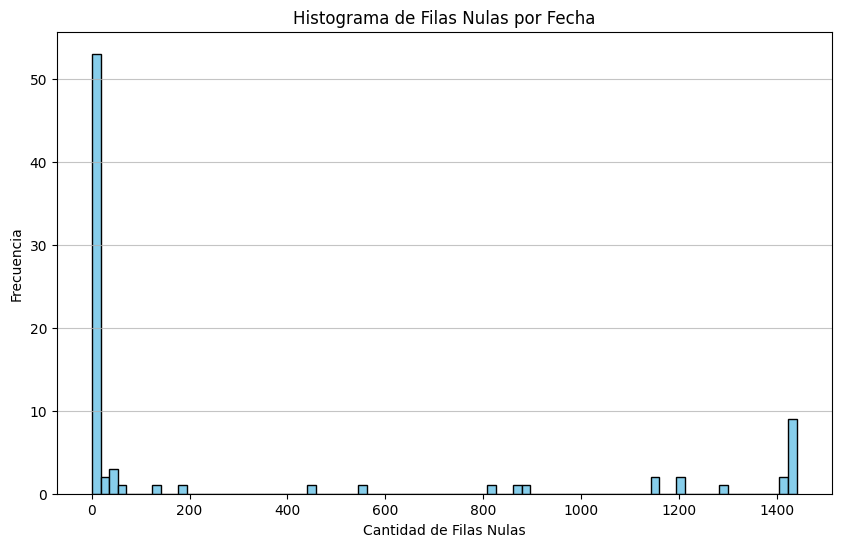

In [12]:
nulos_por_fecha["Date"] = pd.to_datetime(nulos_por_fecha["Date"])
plt.figure(figsize=(10, 6))
plt.hist(nulos_por_fecha["Count"], bins=len(nulos_por_fecha),color='skyblue', edgecolor='black')
plt.title("Histograma de Filas Nulas por Fecha")
plt.xlabel("Cantidad de Filas Nulas")
plt.ylabel("Frecuencia")
plt.grid(axis='y', alpha=0.75)

plt.show()

In [13]:
print(nulos_por_fecha['Count'].describe())

count      82.000000
mean      316.817073
std       548.979190
min         1.000000
25%         1.000000
50%         2.000000
75%       385.750000
max      1440.000000
Name: Count, dtype: float64


In [14]:
# Filas con menos de 5% de valores nulos
print((nulos_por_fecha['Count'] < 73).sum())
# Filas con entre 5% y 50% valores nulos (menos de la mitad del día, asumiendo un día de 1440 minutos)
print(((nulos_por_fecha['Count'] >= 73) & (nulos_por_fecha['Count'] < 720)).sum())
# Filas con mas de 50% valores nulos (mas de la mitad del día, asumiendo un día de 1440 minutos)
print((nulos_por_fecha['Count'] > 720).sum())
# Filas el día completo nulos, asumiendo un día de 1440 minutos
print((nulos_por_fecha['Count'] == 1440).sum())

59
4
19
9


In [15]:
diasComp_null = nulos_por_fecha[nulos_por_fecha['Count'] == 1440]
print(diasComp_null)

         Date  Count
7  2007-04-29   1440
48 2009-06-14   1440
59 2010-01-13   1440
72 2010-08-18   1440
73 2010-08-19   1440
74 2010-08-20   1440
75 2010-08-21   1440
78 2010-09-26   1440
79 2010-09-27   1440


**La distribucion de los datos nulos son**:
-  59 dias solo les falta umenos de 6 registros, es decir de 1 a 5 minutos faltantes de todo el dia
-  4 dias les falta mas de 5% registros y menos del 50% de los registros 
-  10 de ellos les falta mas de 50% porciento de los datos pero no todo el dia
-  9 dias hacen falta los registros completos

Además los registros de días faltantes se distribuyen de la siguiente forma:
- un dia en 2007 de marzo
- un dia en 2009 de junio
- 7 de ellos del 2010, 4 de ellos pertenecen a un mismo mes (agosto) y son dias continuos (18-21). dos de ellos son de septiembre del 26 y27 y finalmente de enero 13

### 2.4 Limpeiza para menos del 5% Faltantes por Día

Para los días que solo les faltan menos del 5%, el método de interpolación lineal es una excelente opción. Este método asume que el cambio entre los puntos de datos disponibles es lineal y puede usarse para estimar los valores faltantes con relativa precisión. Dado que los intervalos de tiempo faltantes son cortos, la interpolación lineal puede proporcionar estimaciones cercanas a los valores reales, minimizando la distorsión de los datos.

In [16]:
grupo1 = nulos_por_fecha[nulos_por_fecha['Count'] < 73].copy()
grupo1['Date'] = pd.to_datetime(grupo1['Date'])

# Combinar las columnas 'Date' y 'Time' para crear una nueva columna 'DateTime'
X_clean['DateTime'] = pd.to_datetime(X_clean['Date'].astype(str) + ' ' + X_clean['Time'])
# Establecer 'DateTime' como el nuevo índice del DataFrame
X_clean.set_index('DateTime', inplace=True)

for fecha in grupo1['Date']:
    # Seleccionar filas para una fecha específica y solo columnas numéricas
    date_mask = X_clean.index.date == fecha.date()
    numeric_columns = X_clean.select_dtypes(include=['float64', 'int64']).columns
    X_clean.loc[date_mask, numeric_columns] = X_clean.loc[date_mask, numeric_columns].interpolate(method='linear')

In [17]:
print(X_clean.isnull().sum())

Date                         0
Time                         0
Global_active_power      25668
Global_reactive_power    25668
Voltage                  25668
Global_intensity         25668
Sub_metering_1           25668
Sub_metering_2           25668
Sub_metering_3           25668
dtype: int64


Para los demás datos va a ser ignorados en cuanto a las predicciones

## 3. Creación de datos agrupados por dia

In [18]:
columns_to_keep = ['Date'] + X_clean.columns[-7:].tolist()
Xa = X_clean[columns_to_keep]
Xa.set_index('Date', inplace=True)
daily_sum = Xa.resample('D').sum()

In [19]:
print(daily_sum.head())

            Global_active_power  Global_reactive_power    Voltage  \
Date                                                                
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
Date                                                                          
2006-12-16            5180.8             0.0           546.0          4926.0  
2006-12-17           14398.6          2033.0          4187.0         13341.0  
2006-12-18            9247.2          1063.0          2621.0         14018.0  
2006-12-19            7094.0           839.0          7602.0          6197.0  
2006-12-20            9313.0             0

## 4. Seleccion de variables indepndientes

Se tiene que determinar la mejor variable independiente en una regresión lineal donde Global_active_power es la variable dependiente

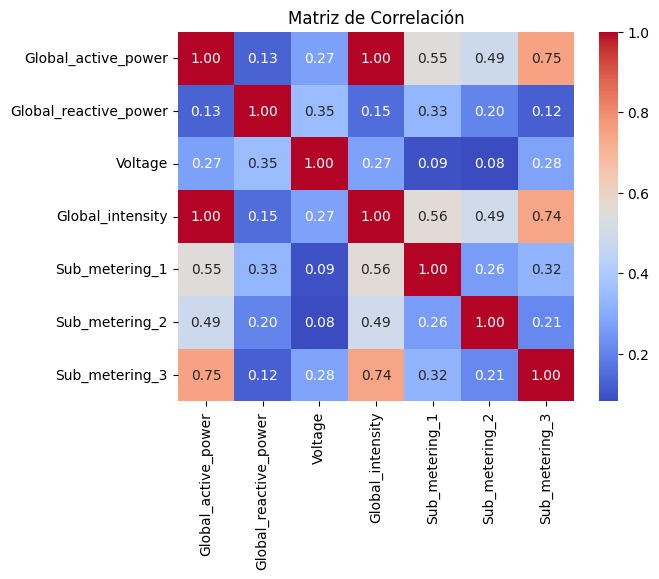

In [20]:
# Calcula la matriz de correlación
correlation_matrix = daily_sum.corr()

# Crear un mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

La variable con el mayor correlación con Global_active_power es **Global_intensity**, segidas de **Sub_metering_3**, **Sub_metering_1** y **Sub_metering_2**. sin embargo la variable de global intensity al tener una correlaión de 1 no se puede determinar como una variable independiente confiable. Por lo tanto se ocupa Sub_metering 3 como la variable de mayor correlación.

## 5. Modelos de regresion lineal simple

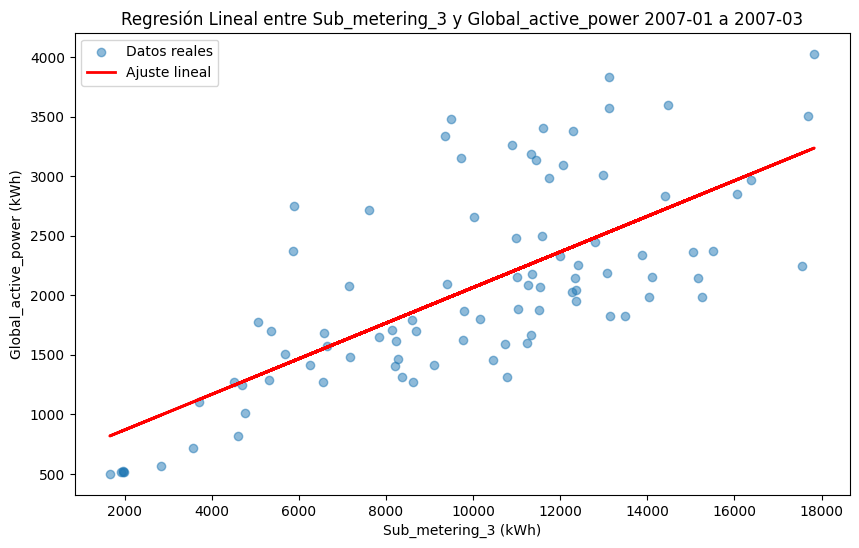

In [21]:
enero_marzo_2007 = daily_sum['2007-01-01':'2007-03-31']

X = enero_marzo_2007['Sub_metering_3'].values.reshape(-1, 1)  # Característica independiente
y = enero_marzo_2007['Global_active_power'].values  # Variable objetivo

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)
# Predecir los valores de y basados en X
y_pred = model.predict(X)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Datos reales')
plt.plot(X, y_pred, color='red', linewidth=2, label='Ajuste lineal')
plt.title('Regresión Lineal entre Sub_metering_3 y Global_active_power 2007-01 a 2007-03')
plt.xlabel('Sub_metering_3 (kWh)')
plt.ylabel('Global_active_power (kWh)')
plt.legend()
plt.show()

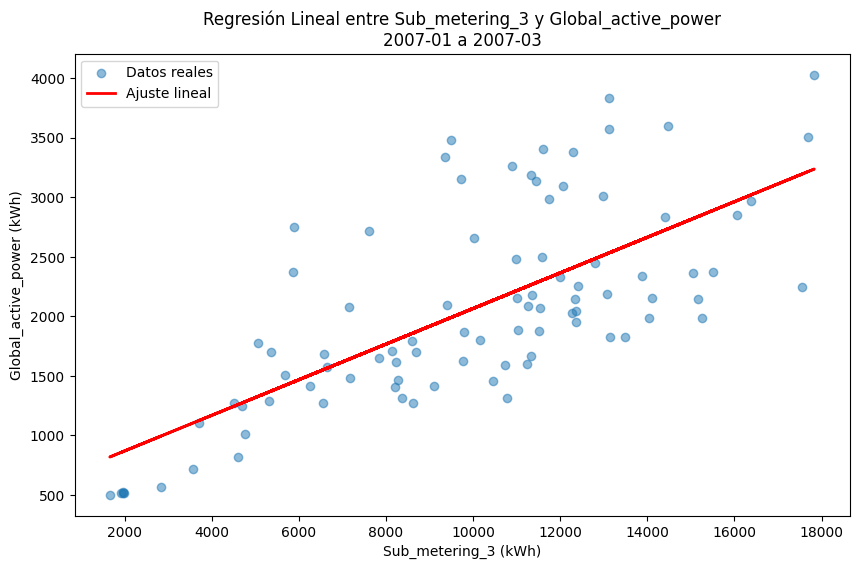

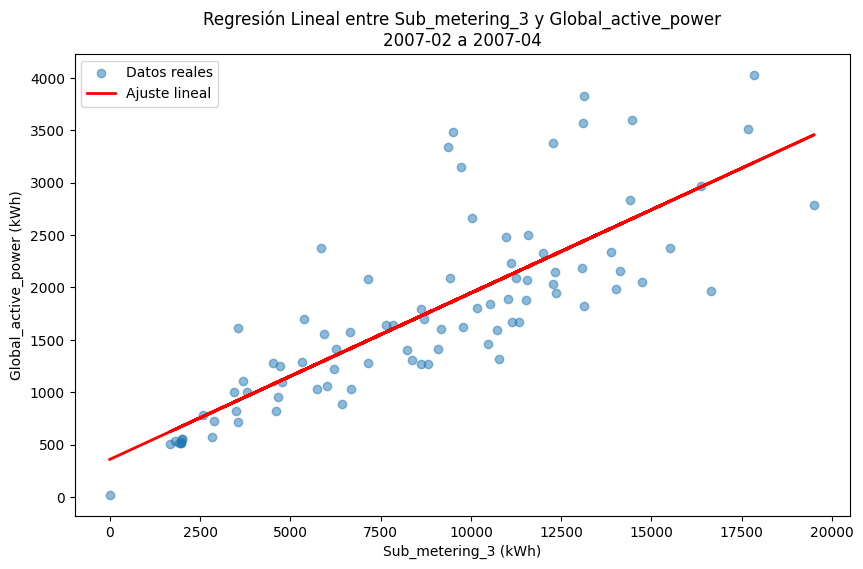

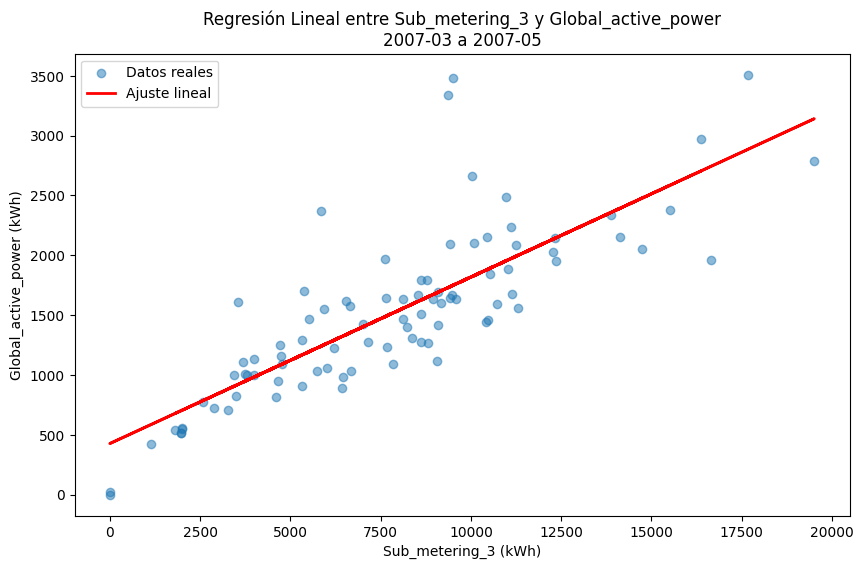

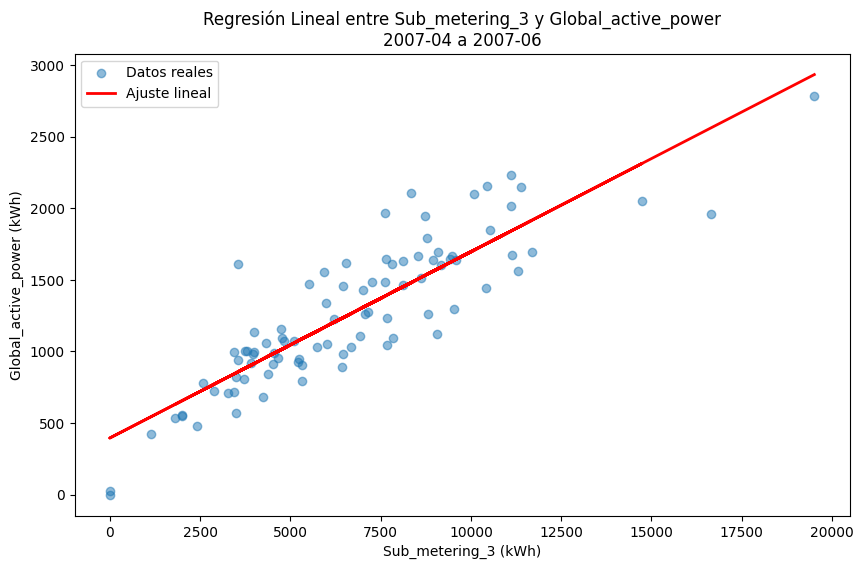

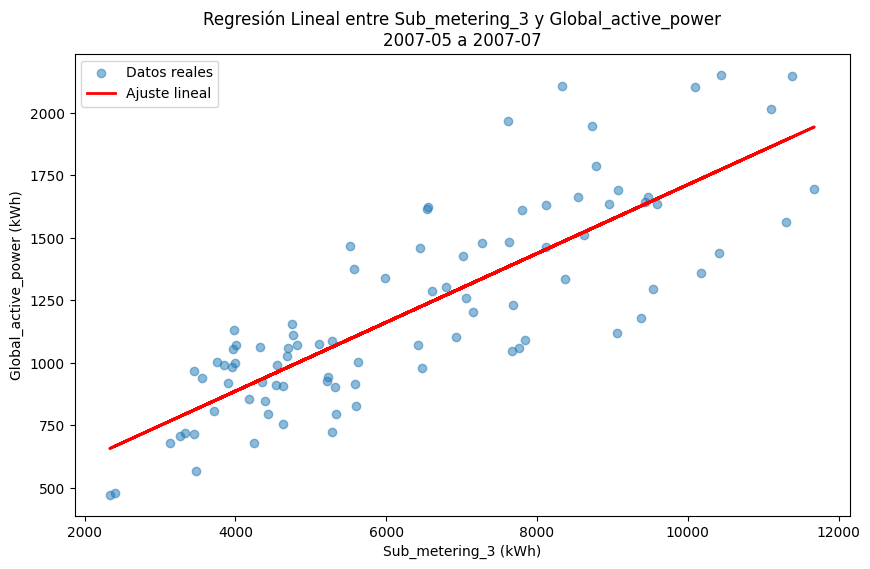

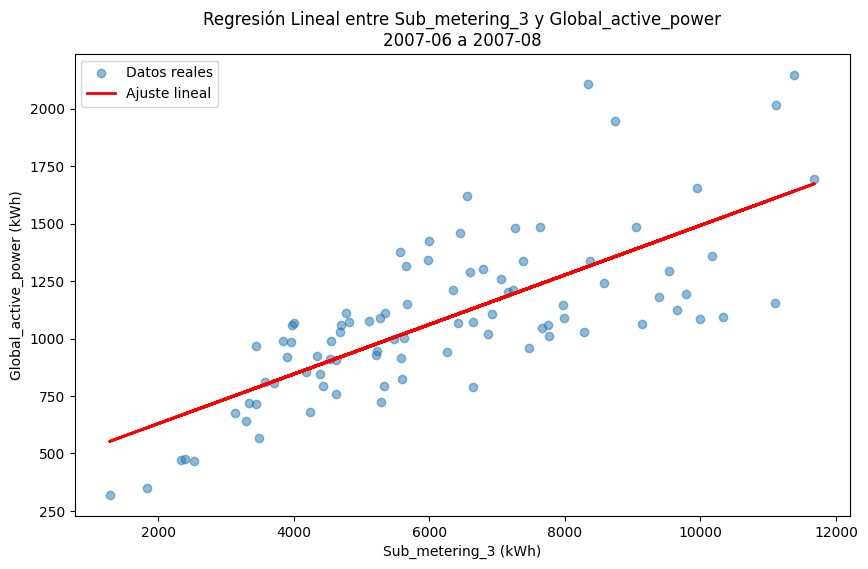

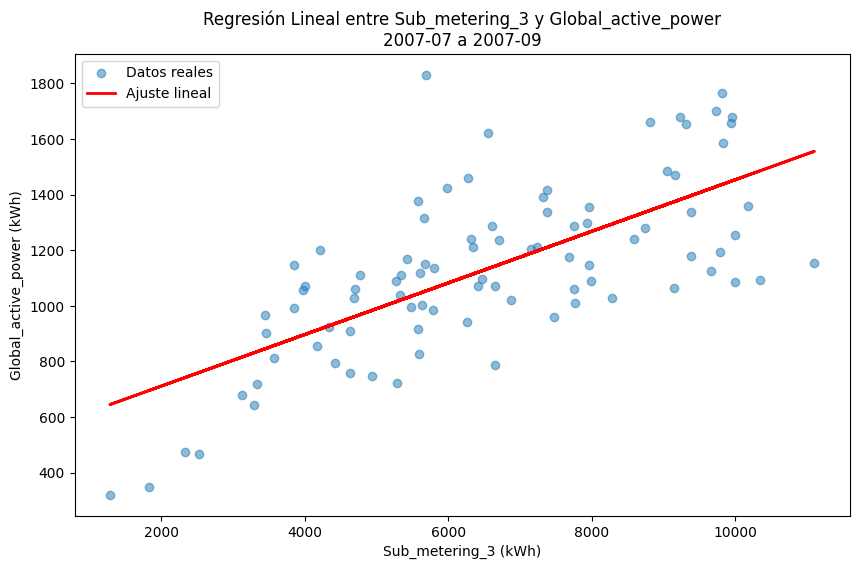

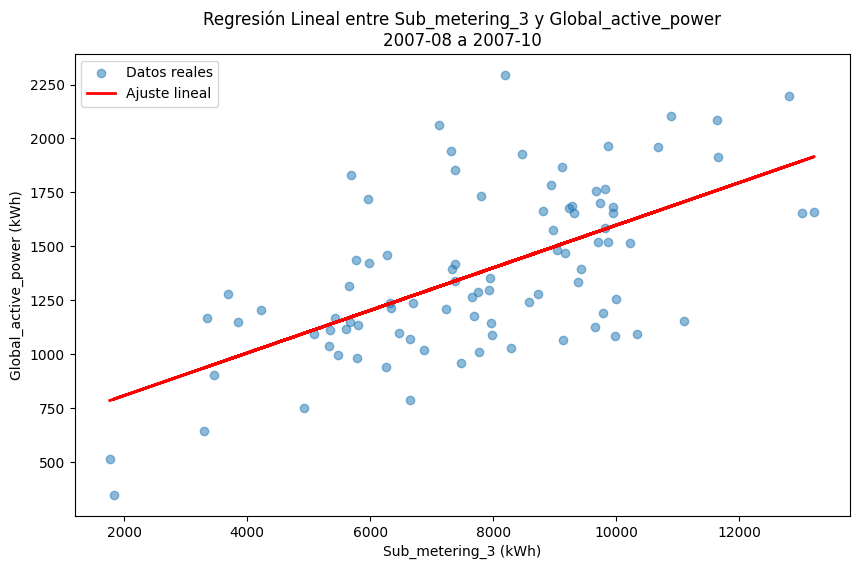

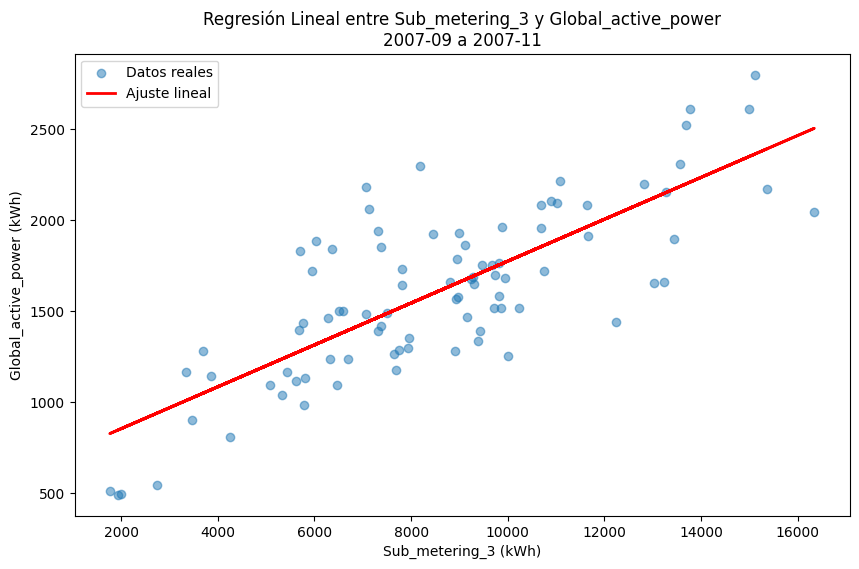

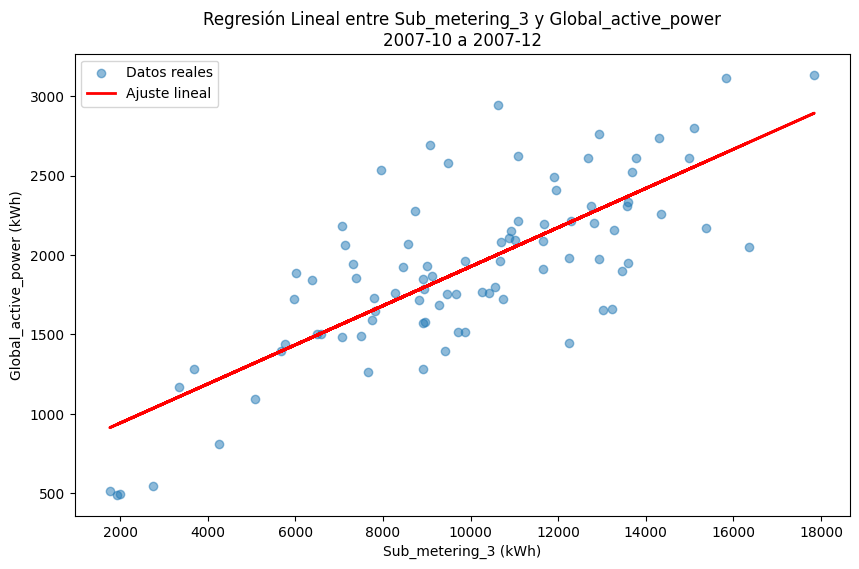

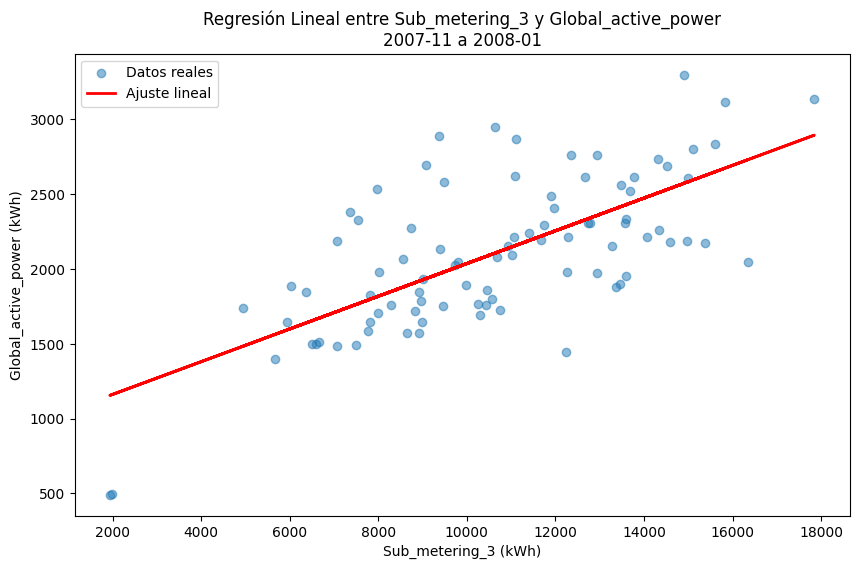

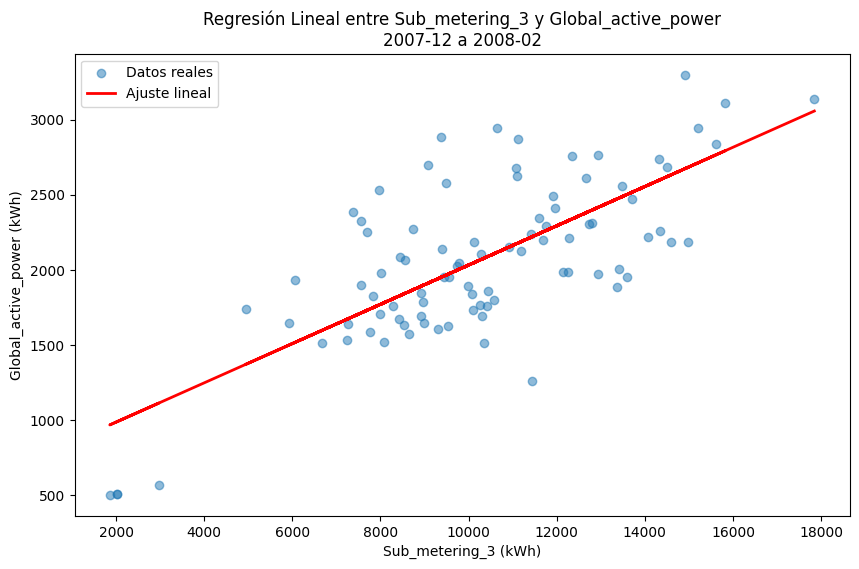

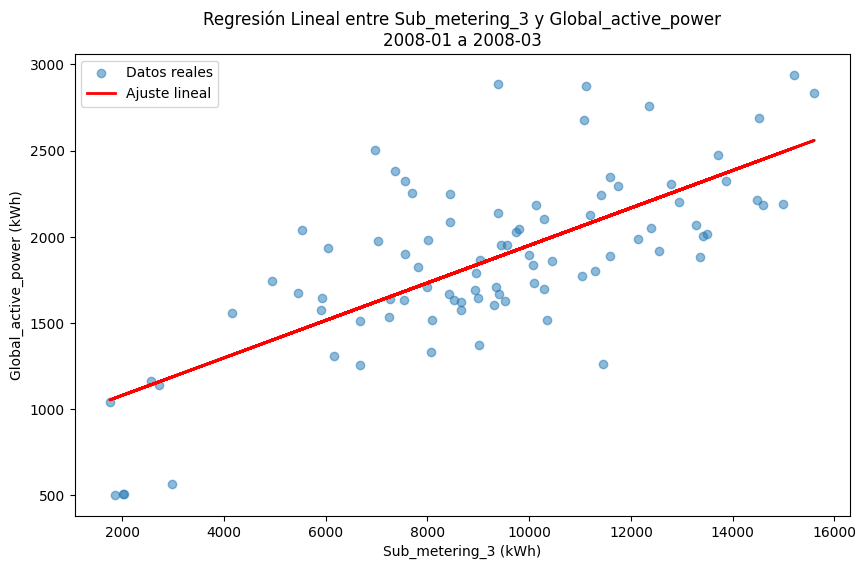

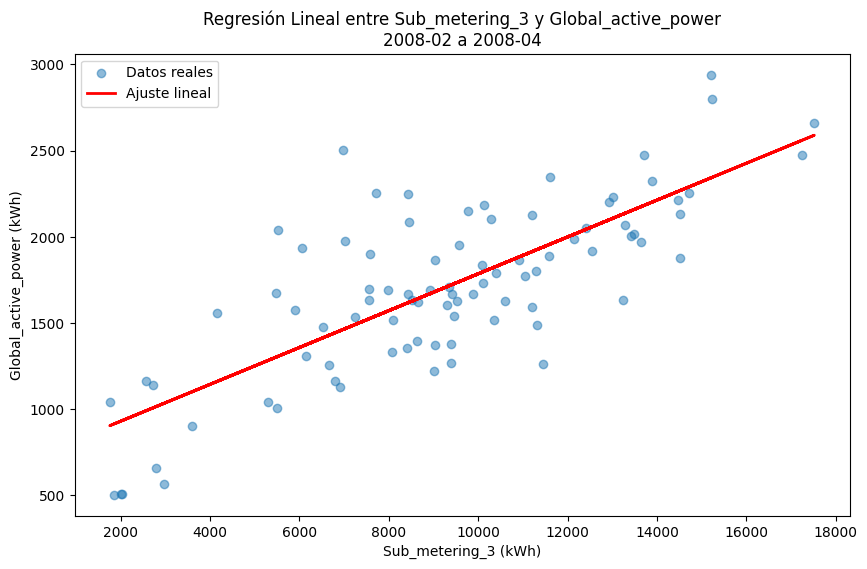

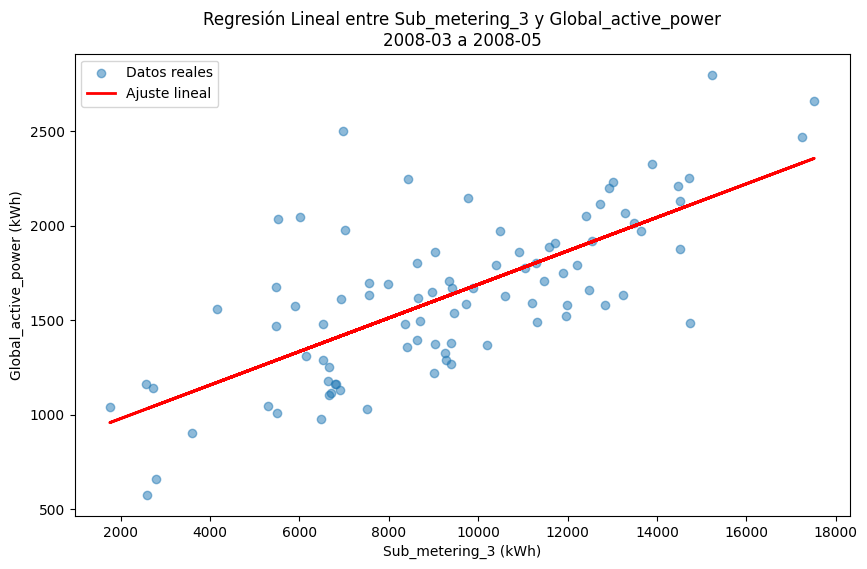

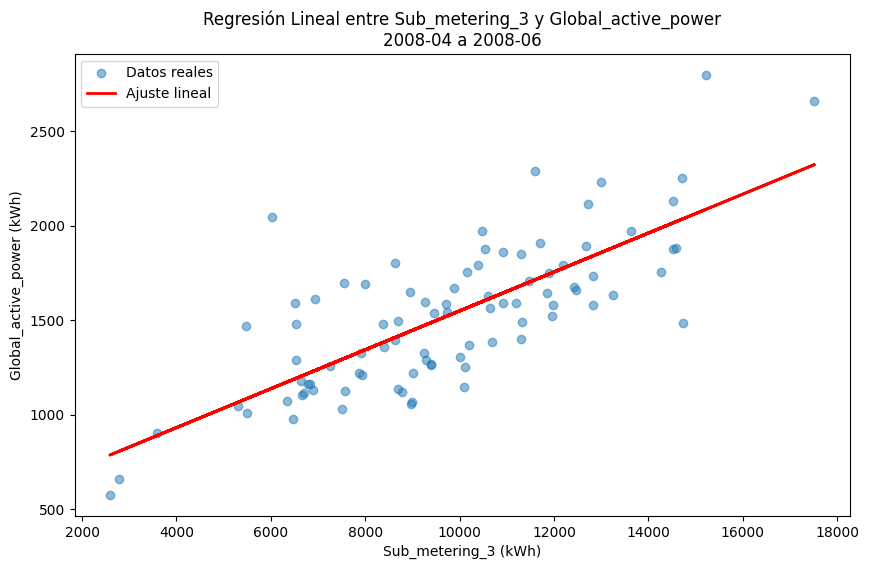

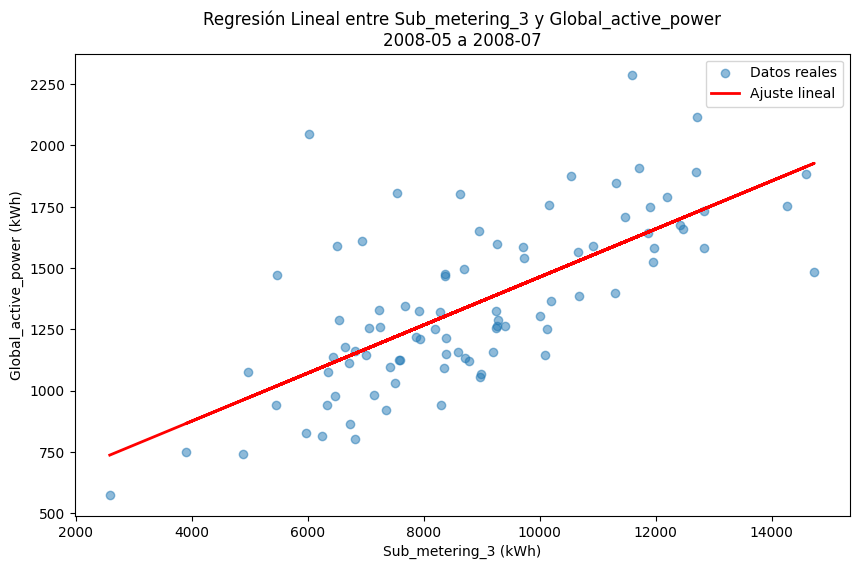

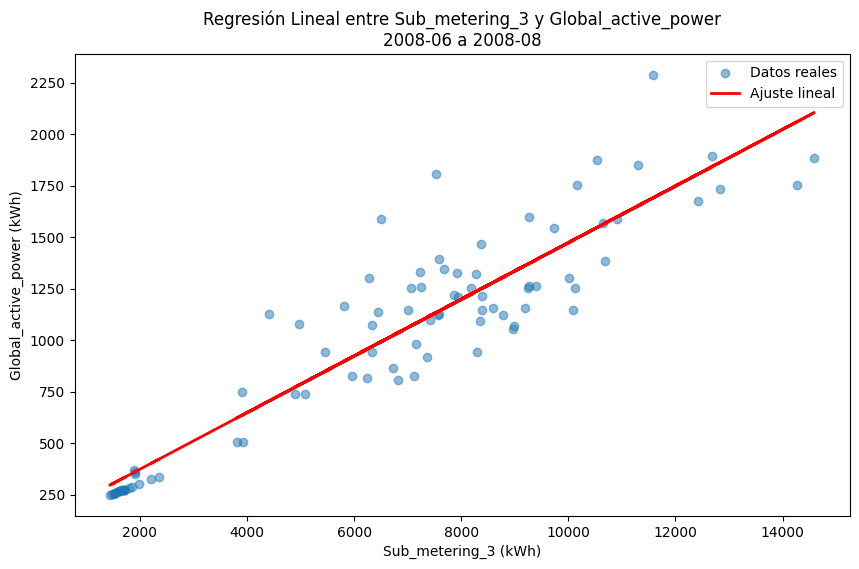

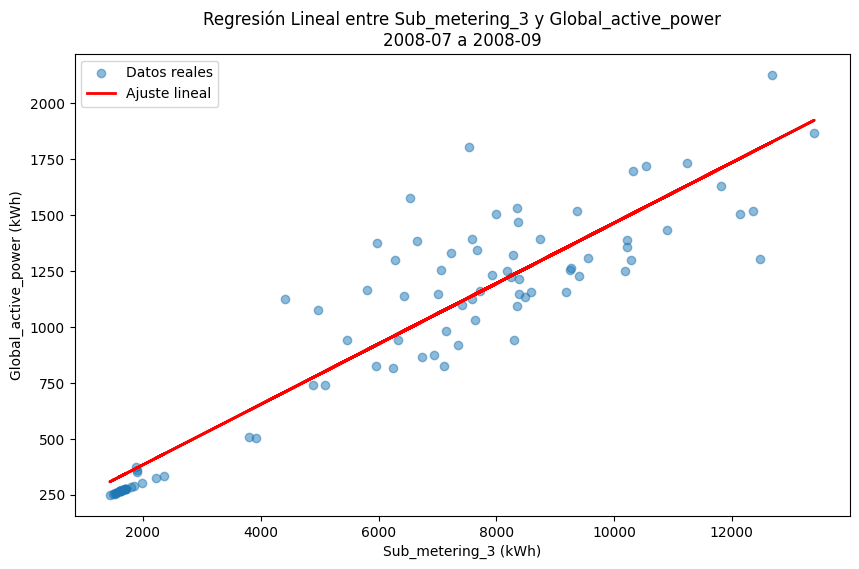

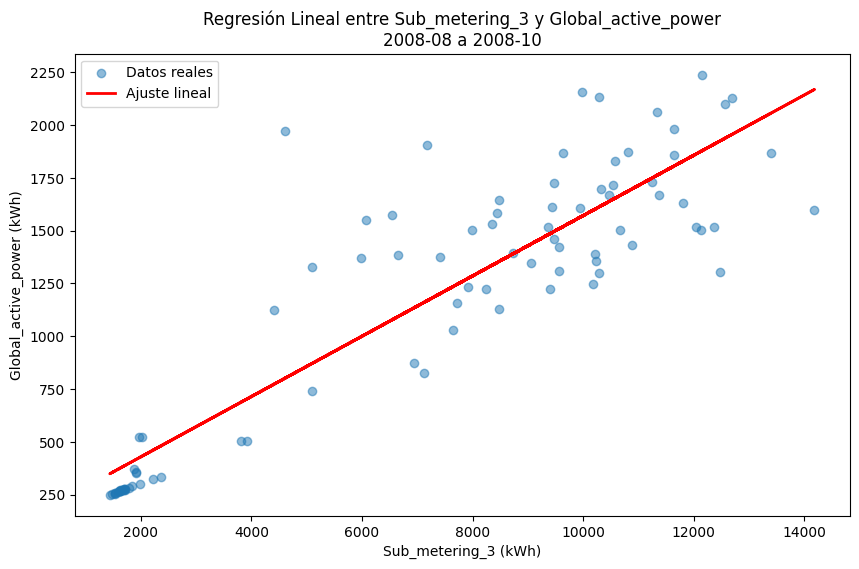

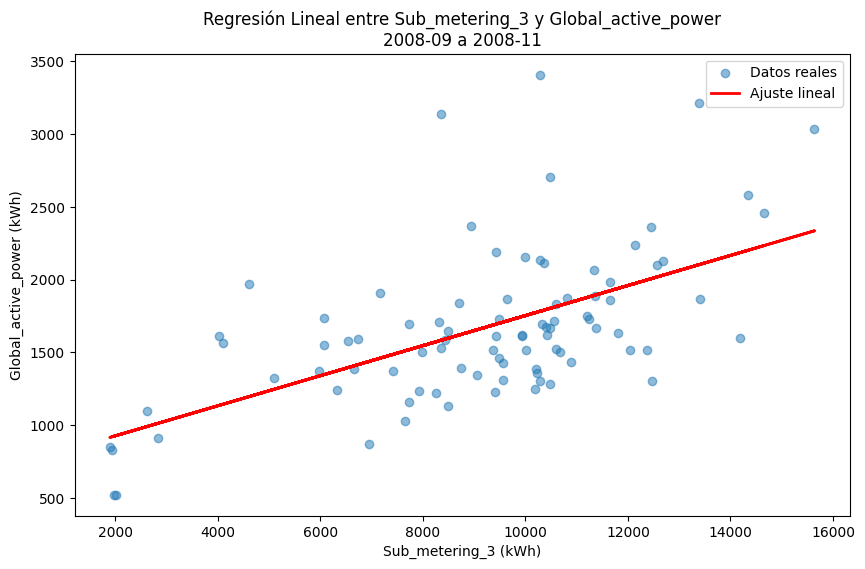

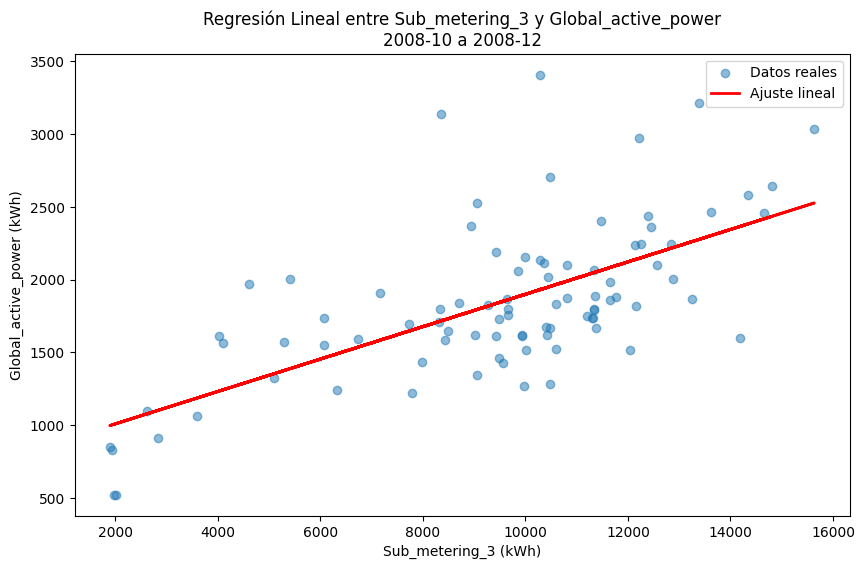

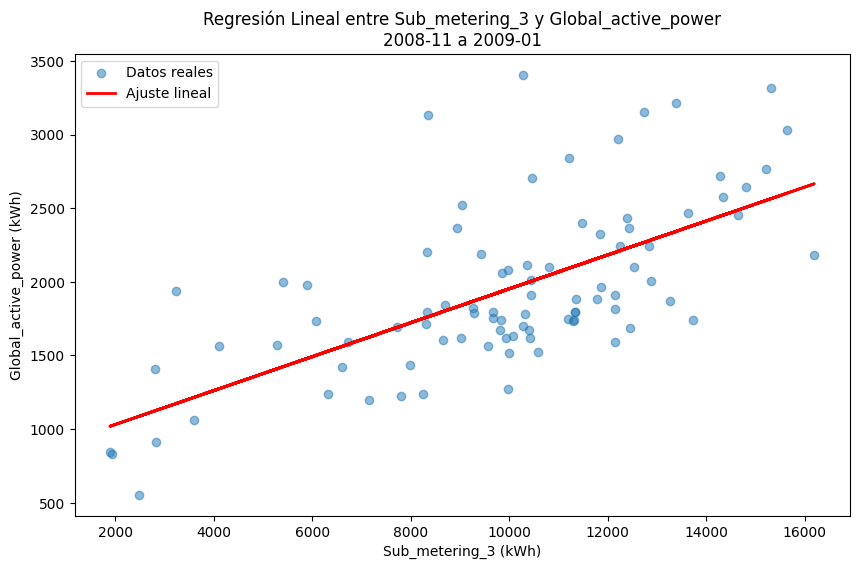

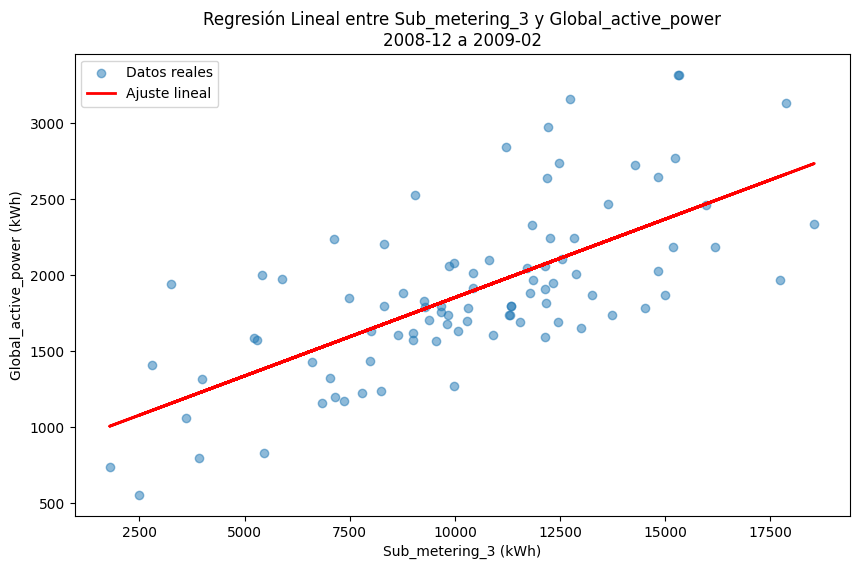

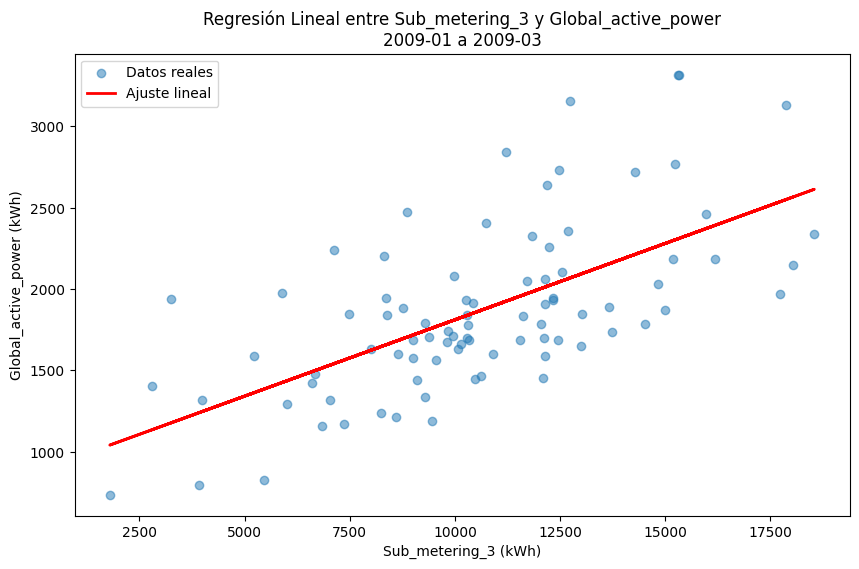

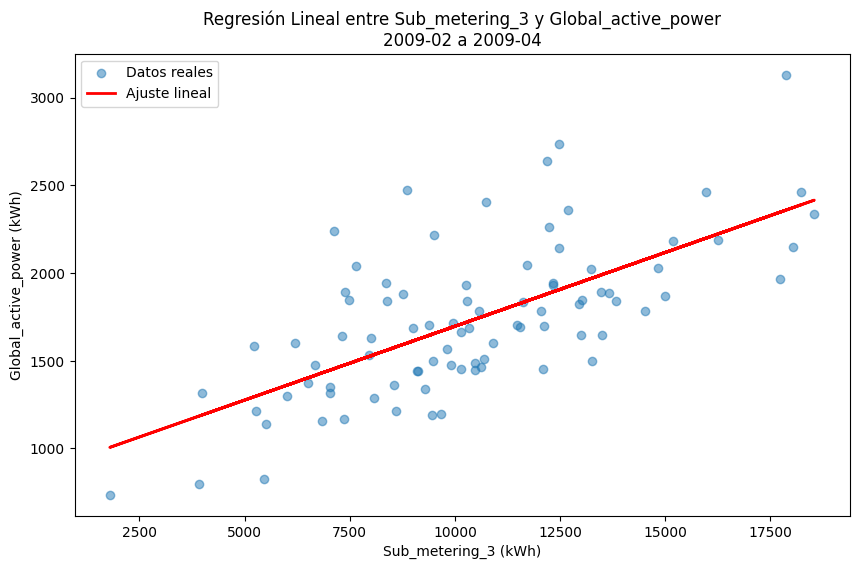

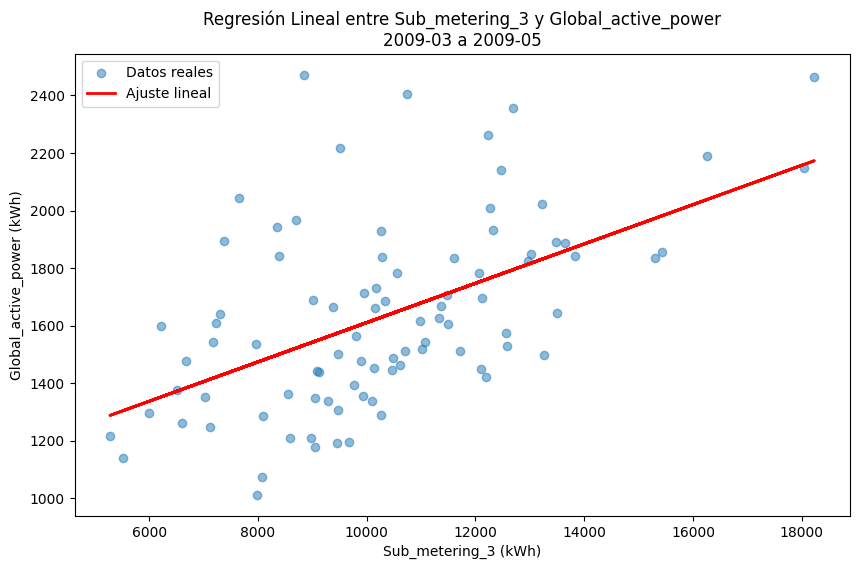

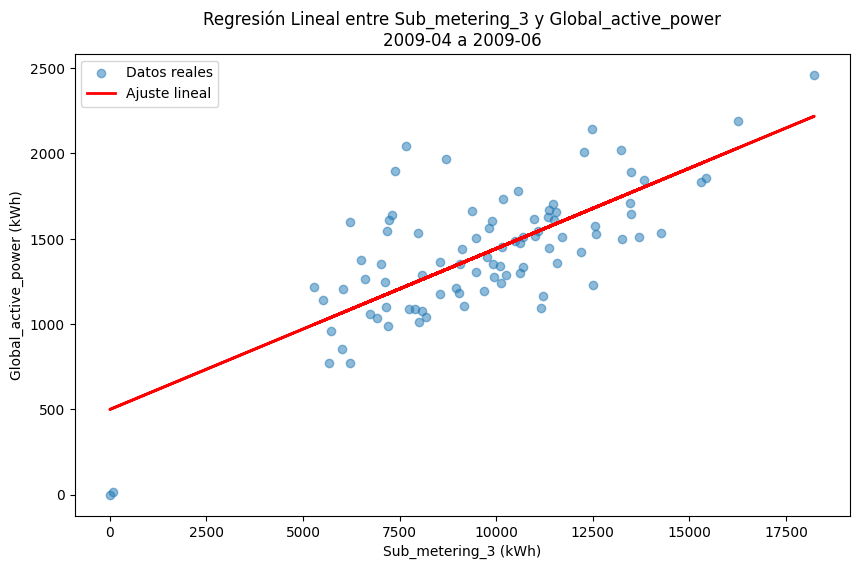

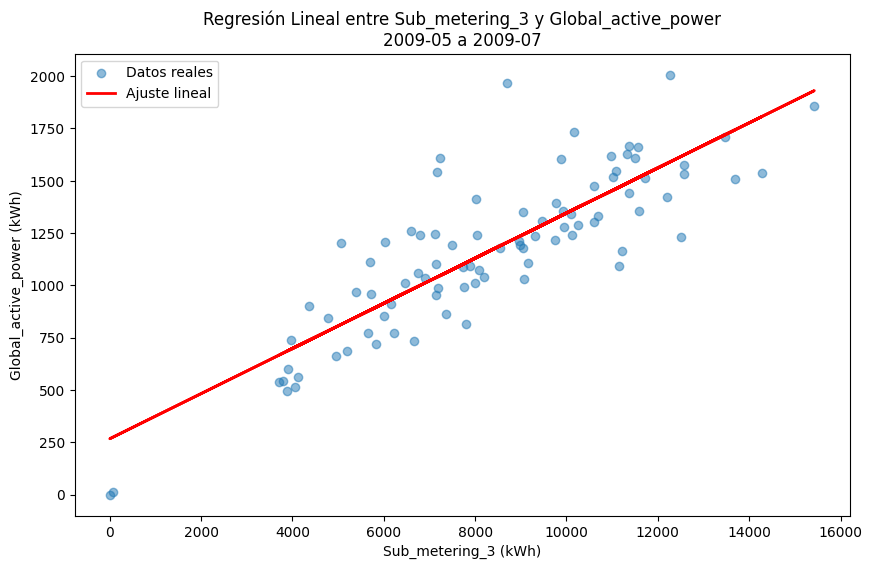

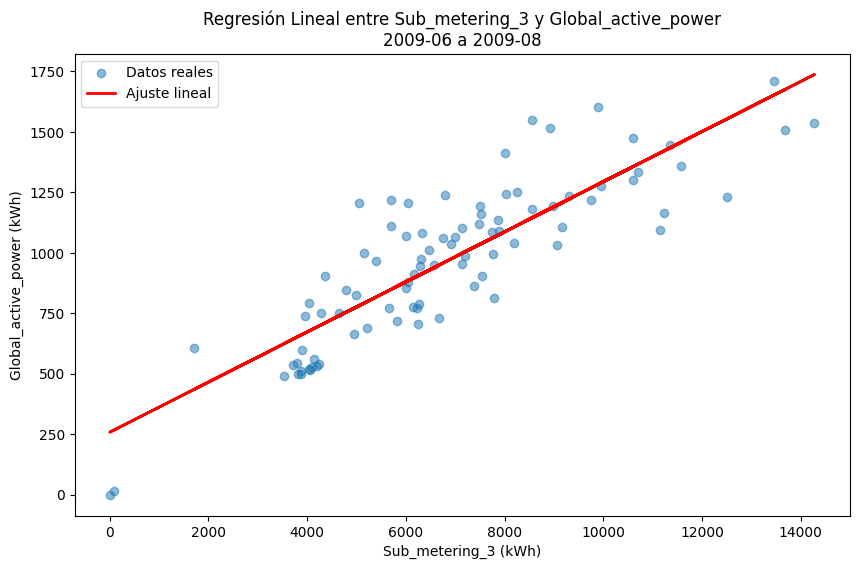

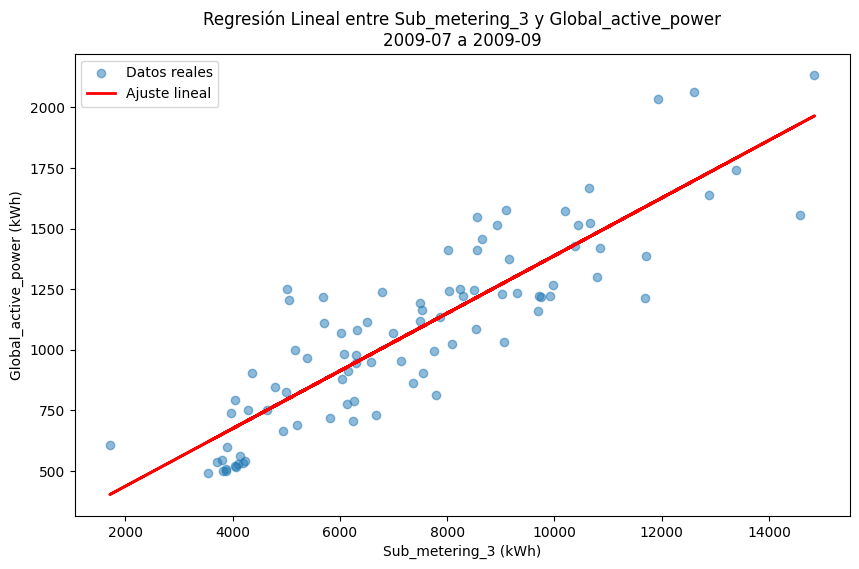

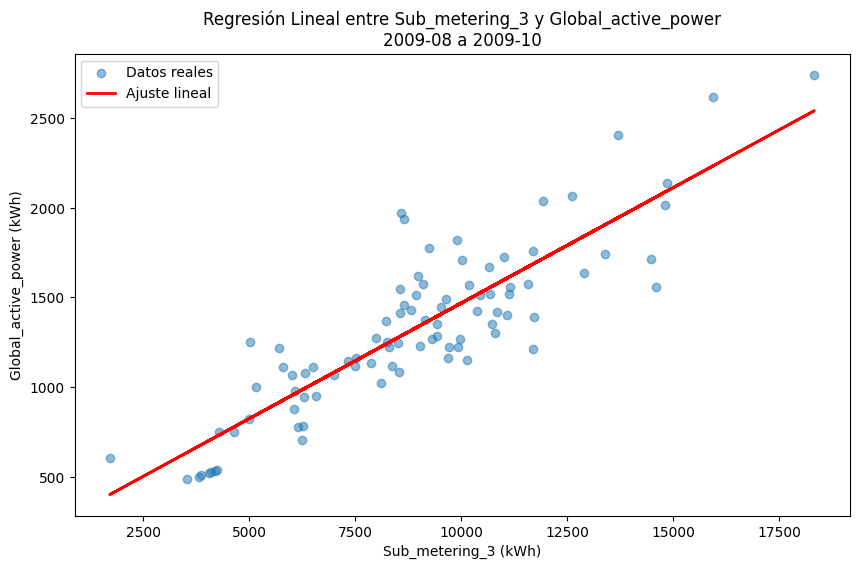

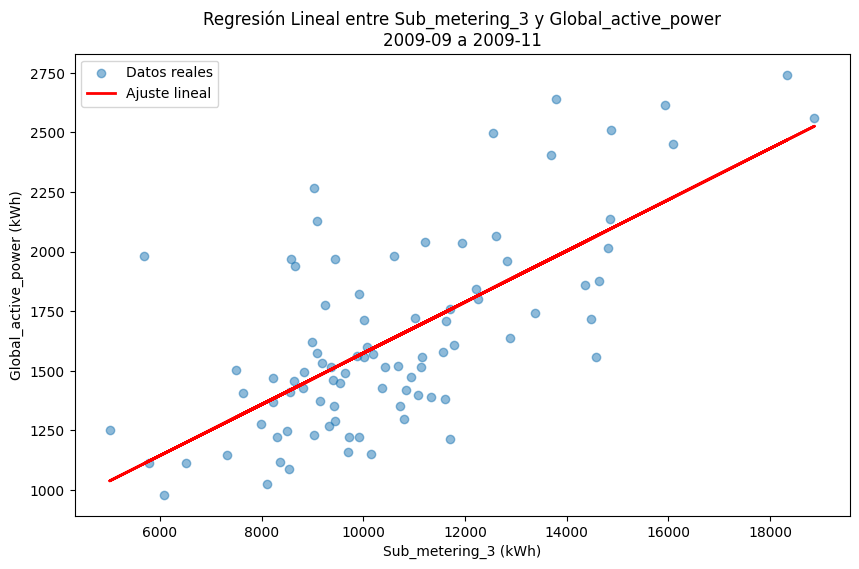

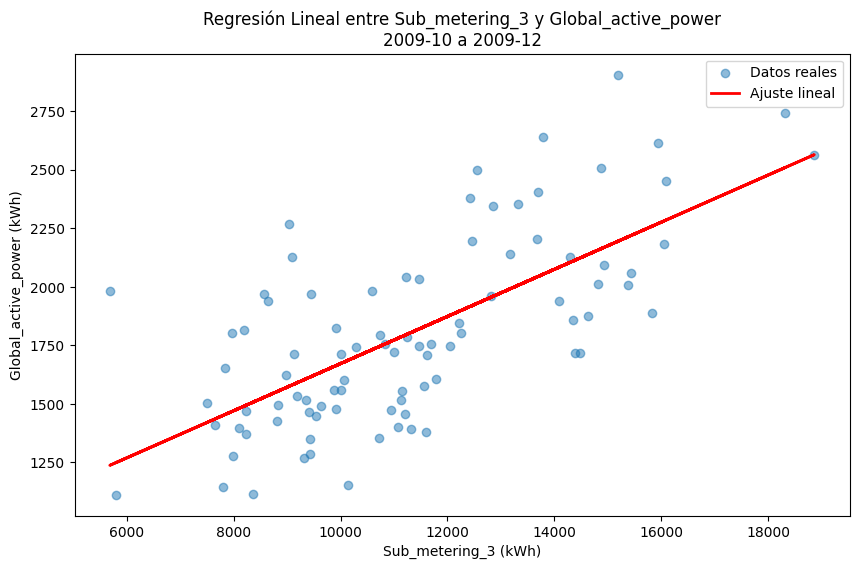

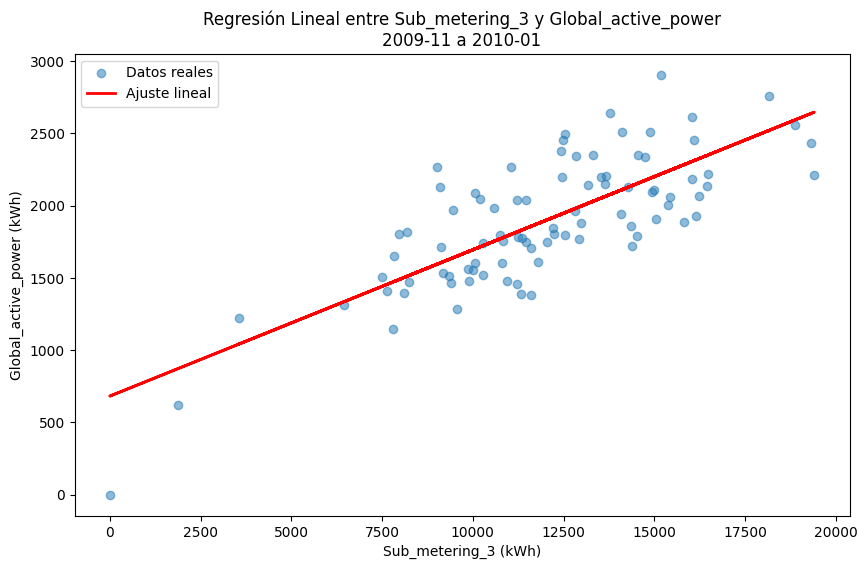

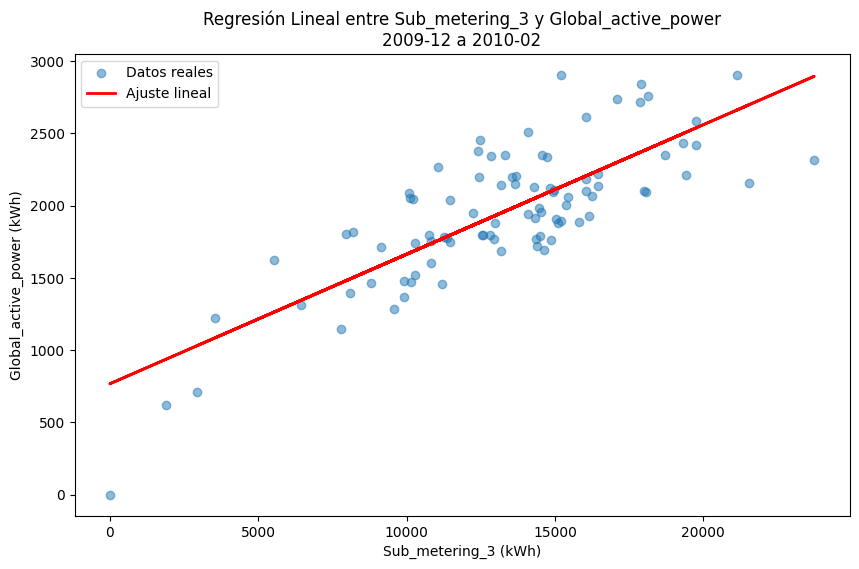

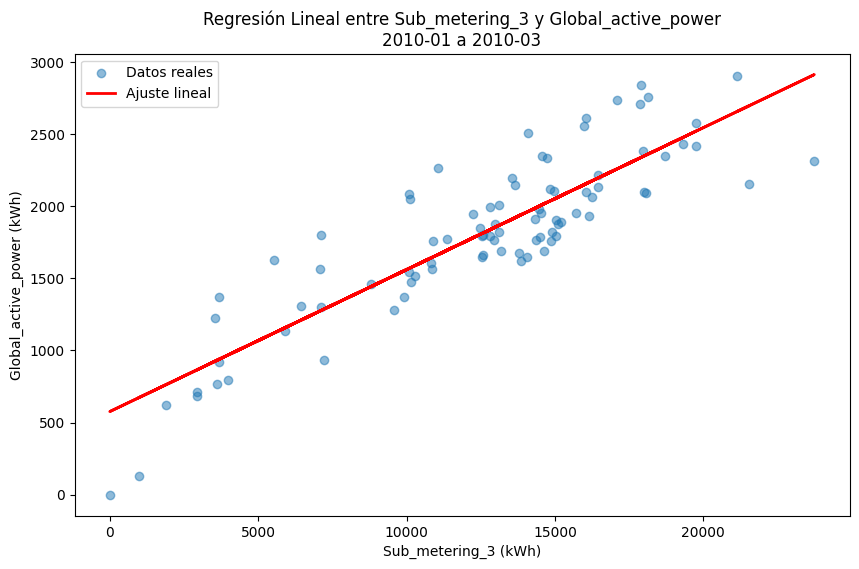

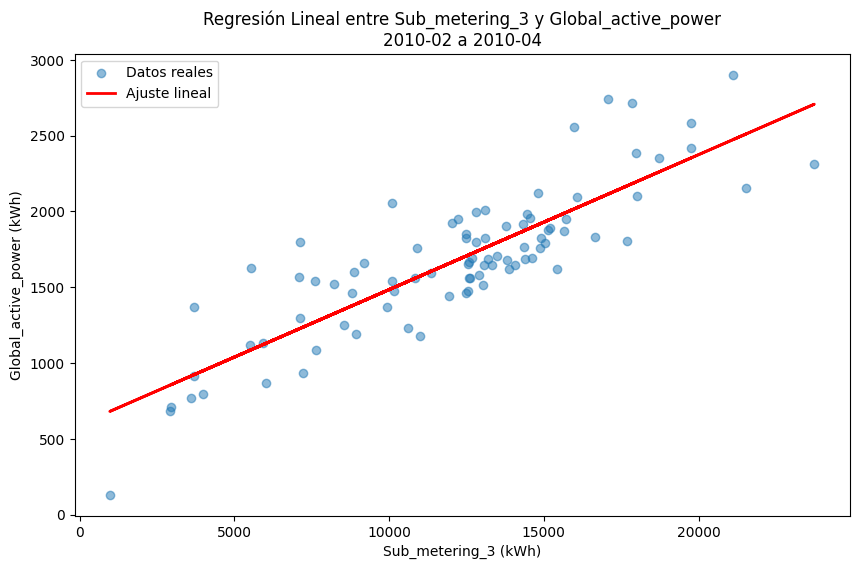

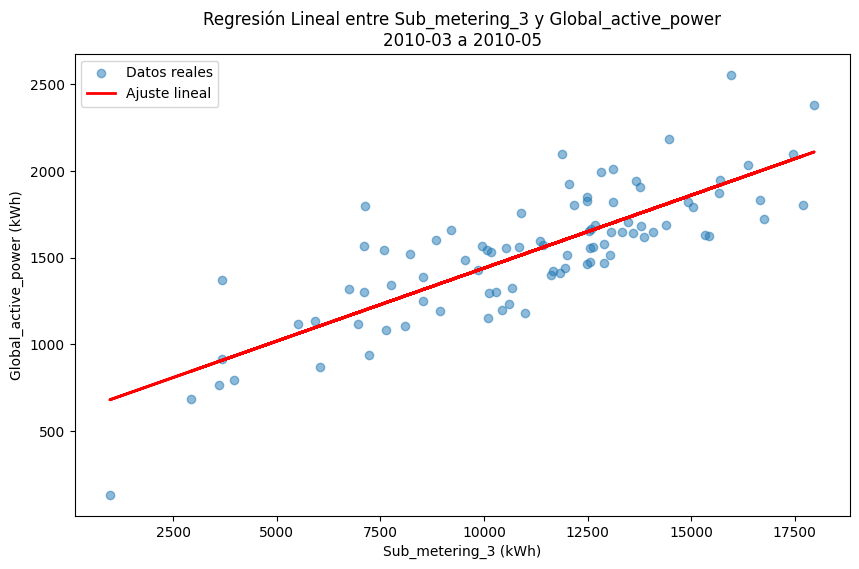

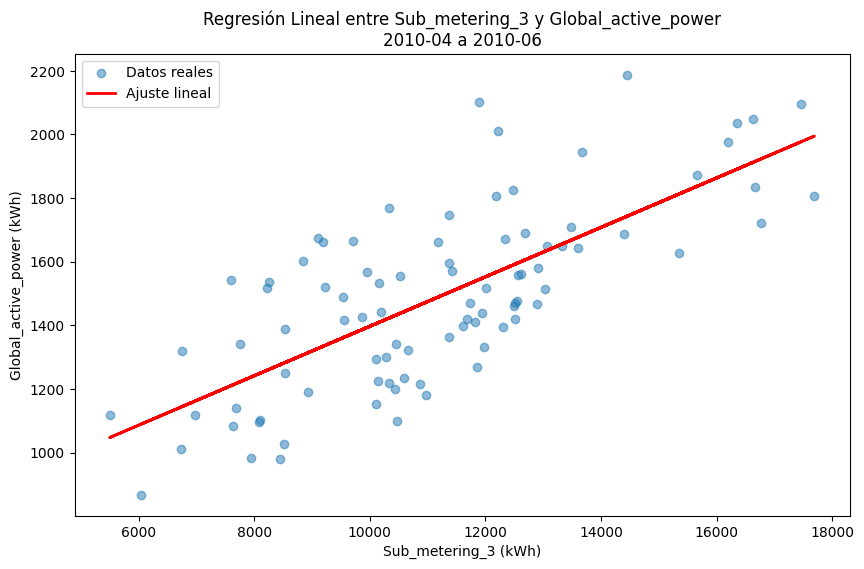

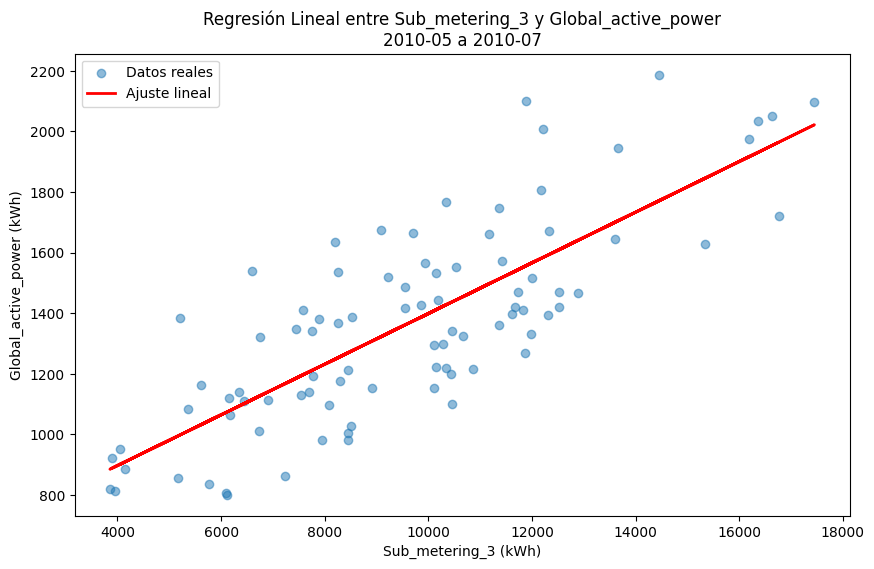

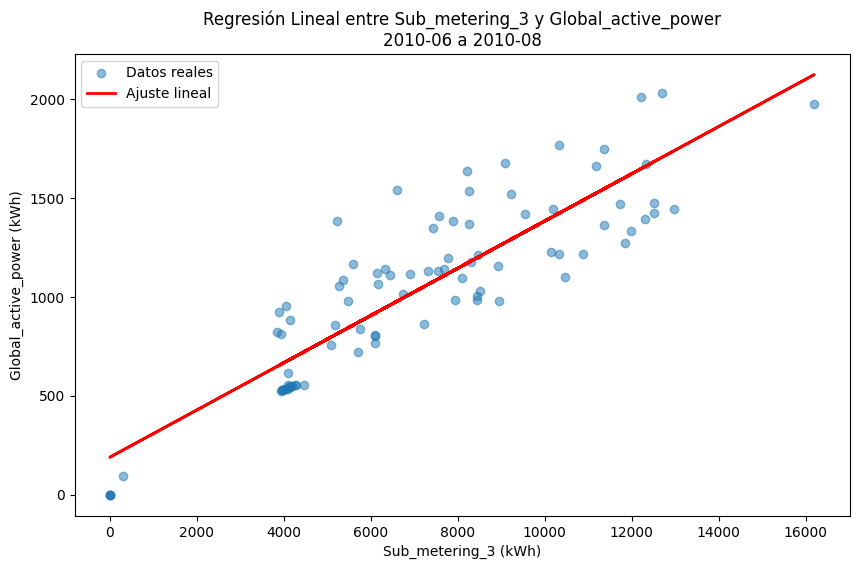

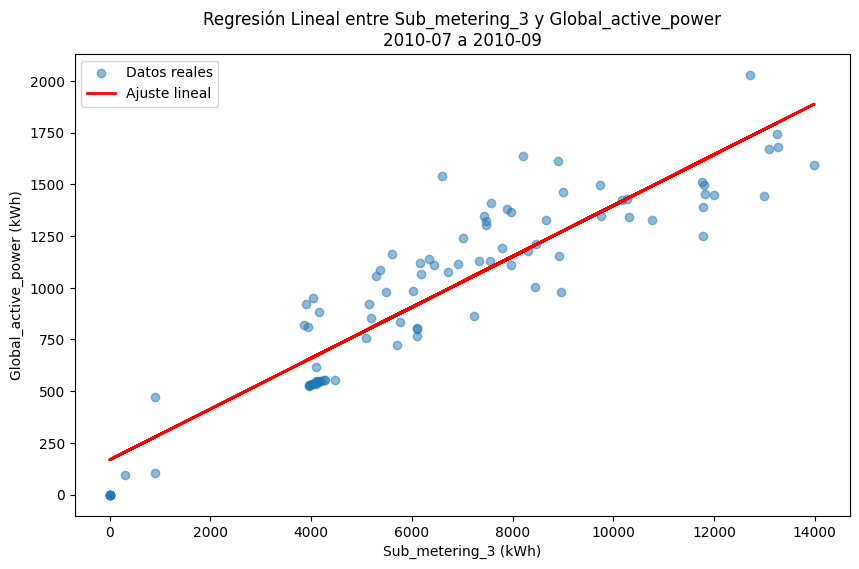

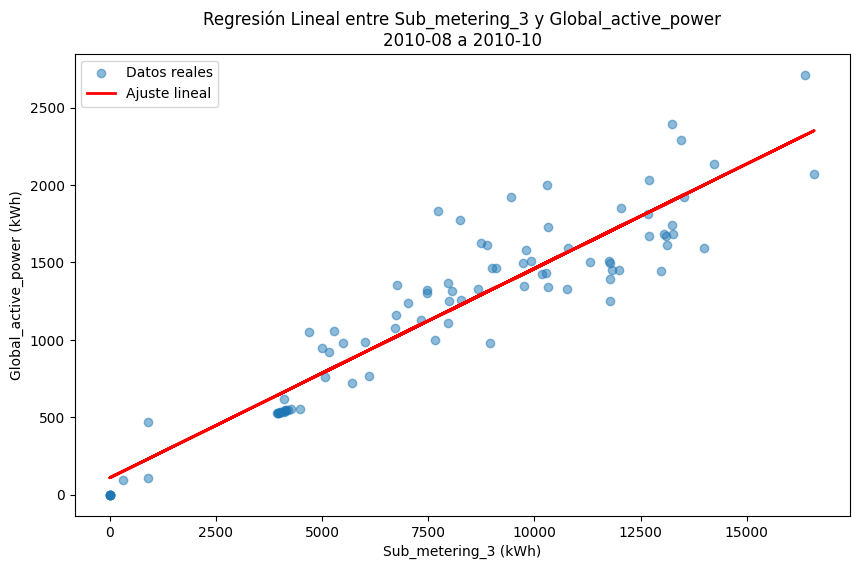

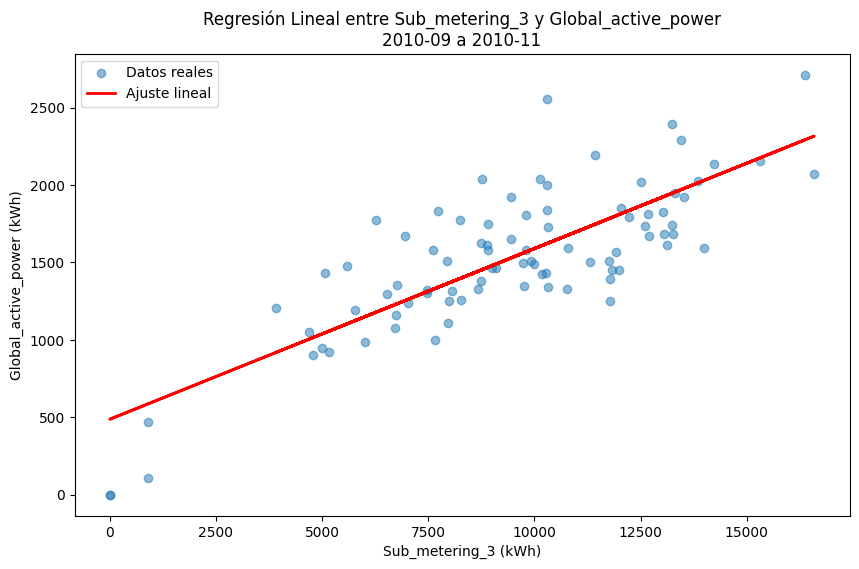

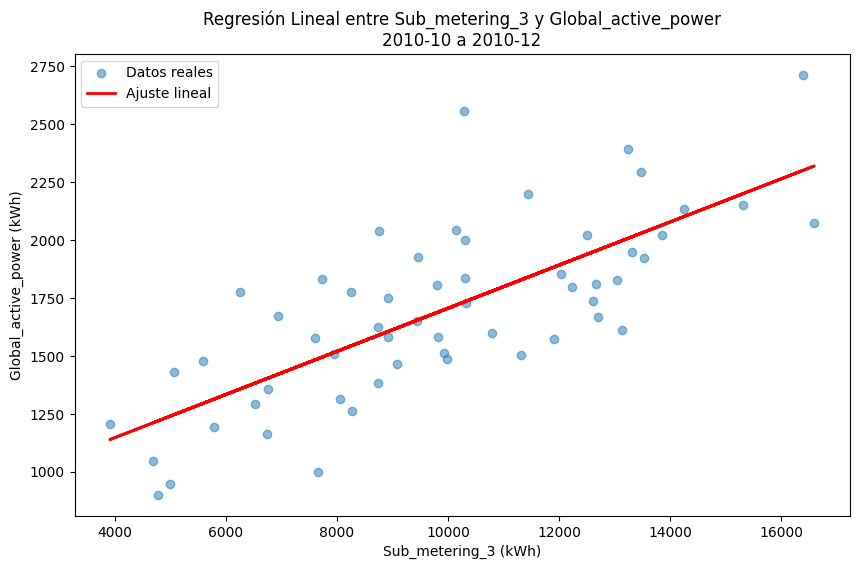

In [22]:
start_date = pd.to_datetime('2007-01-01')
end_date = pd.to_datetime('2010-12-31')
end_date_month = pd.to_datetime('2007-01-31')
modelos = []

while start_date + pd.DateOffset(months=2) <= end_date:
    # Seleccionar el rango de tres meses
    three_months_data = daily_sum[start_date:end_date_month + pd.DateOffset(months=2)]
    
    # Preparar los datos para la regresión
    X = three_months_data['Sub_metering_3'].values.reshape(-1, 1)  # Característica independiente
    y = three_months_data['Global_active_power'].values  # Variable objetivo
    
    # Crear y entrenar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)
    modelos.append(model)
    
    # Predecir los valores de y basados en X
    y_pred = model.predict(X)
    
    
   # Crear la gráfica
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.5, label='Datos reales')
    plt.plot(X, y_pred, color='red', linewidth=2, label='Ajuste lineal')
    end_range_date = start_date + pd.DateOffset(months=2)
    plt.title(f'Regresión Lineal entre Sub_metering_3 y Global_active_power\n{start_date.strftime("%Y-%m")} a {end_range_date.strftime("%Y-%m")}')
    plt.xlabel('Sub_metering_3 (kWh)')
    plt.ylabel('Global_active_power (kWh)')
    plt.legend()
    plt.show()
    
    start_date += pd.DateOffset(months=1)
    end_date_month += pd.DateOffset(months=1)

## 6. Predicciónes

In [23]:
print(modelos[0])

LinearRegression()


In [24]:
prediction_start_date = pd.to_datetime('2007-04-01')
prediction_end_date = pd.to_datetime('2010-12-31')

# Función para hacer predicciones basadas en los modelos entrenados
def predict_with_models(modelos, daily_sum, start_date, end_date):
    results = pd.DataFrame(columns=['Date', 'Submetering_3', 'Pred_GAP', 'Real_GAP'])
    current_date = start_date
    current_month = None
    model = None
    i = 0
    while current_date <= end_date:
        if current_date in daily_sum.index:
            if current_date.month != current_month:
                # Cambio de mes, seleccionamos un nuevo modelo
                current_month = current_date.month
                model = modelos[i]  # Rotamos entre los modelos
                i += 1

            X = daily_sum.at[current_date, 'Sub_metering_3']
            real_power = daily_sum.at[current_date, 'Global_active_power']  # Asumiendo que existe esta columna
            y_pred = model.predict([[X]])

            # Almacenar resultado en DataFrame
            temp_df = pd.DataFrame({
                'Date': [current_date],
                'Submetering_3': [X],
                'Pred_GAP': [y_pred.item()],  # Extraemos el valor predicho
                'Real_GAP': [real_power]
            })
            results = pd.concat([results, temp_df])

        current_date += pd.DateOffset(days=1)

    return results

# Ejemplo de uso de la función
# Asumiendo que 'modelos' y 'daily_sum' son definidos anteriormente
results = predict_with_models(modelos, daily_sum, prediction_start_date, prediction_end_date)

# Mostrar los primeros resultados
print(results.head())

C:\Users\matun\AppData\Local\Temp\ipykernel_3584\2083046087.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, temp_df])


        Date  Submetering_3     Pred_GAP  Real_GAP
0 2007-04-01        19509.0  3487.008414  2785.952
0 2007-04-02        16641.0  3058.053201  1960.778
0 2007-04-03         7637.0  1711.361171  1642.820
0 2007-04-04        14748.0  2774.924812  2051.868
0 2007-04-05        10523.0  2143.008572  1844.078


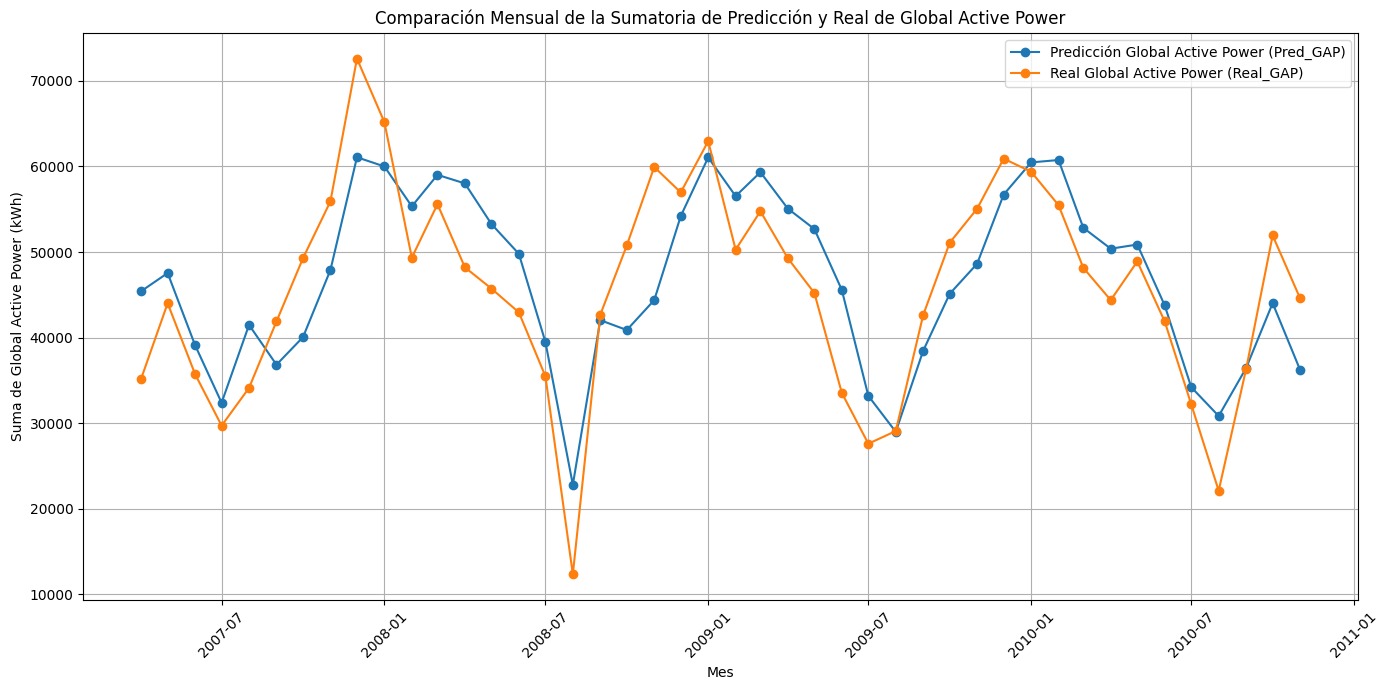

In [26]:
results['month_year'] = results['Date'].dt.to_period('M')

# Agrupar por la nueva columna y sumar los valores
monthly_data = results.groupby('month_year').agg({
    'Pred_GAP': 'sum',
    'Real_GAP': 'sum'
}).reset_index()

# Convertir el 'month_year' de Period a datetime para graficar
monthly_data['month_year'] = monthly_data['month_year'].dt.to_timestamp()

# Graficar los datos
plt.figure(figsize=(14, 7))
plt.plot(monthly_data['month_year'], monthly_data['Pred_GAP'], label='Predicción Global Active Power (Pred_GAP)', marker='o')
plt.plot(monthly_data['month_year'], monthly_data['Real_GAP'], label='Real Global Active Power (Real_GAP)', marker='o')
plt.title('Comparación Mensual de la Sumatoria de Predicción y Real de Global Active Power')
plt.xlabel('Mes')
plt.ylabel('Suma de Global Active Power (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Ajustar la rotación de las etiquetas del eje X para mejorar la legibilidad
plt.tight_layout()  # Ajusta automáticamente los parámetros de la figura para dar espacio a las etiquetas
plt.show()